# Vector Reflectivity Equation Comparison

This notebook compares the forward and adjoint operators of different forms of the vector reflectivity based acoustic wave equation.

In [190]:
import numpy as np
from devito import *
from examples.seismic import setup_geometry, demo_model, RickerSource, Receiver, plot_velocity,\
    plot_shotrecord, ModelViscoacoustic
from examples.seismic.preset_models import Gardners

from examples.seismic.vector_reflectivity.model_creators import model_layer, model_marmousi


# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sympy import latex
from IPython.display import Latex

## Source and receivers creators


In [191]:
# Function to create sources and receivers
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis, npoint=1)
    # print(geometry.f0)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec


# Function to create adjoint sources
def adjoint_src(model, geometry, src_pos):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=1)

    srca.coordinates.data[:, 0] = src_pos[0]
    srca.coordinates.data[:, 1] = src_pos[1]

    return srca

def adjoint_line_src(model, geometry, src_depth, nsrc):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=nsrc)

    srca.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nsrc)
    srca.coordinates.data[:, 1] = src_depth

    return srca

## Acquisition geometry and model

In [192]:
# Parameters

# NX = 101
# NZ = 101

# SHAPE = (NX, NZ)
# ORIGIN = (0, 0)
# SPACING = (5, 5)
# NLAYERS = 2
# SPACE_ORDER = 2
TIME_ORDER = 2
# DTYPE = np.float64
# NBL = 50

In [193]:
def gen_vp(vp_list: list, shape, dtype = np.float64):
    vp = np.ones(shape, dtype)
    nlayers = len(vp_list)
    
    for i, vpi in enumerate(vp_list):
        idx_top = i*shape[1]//nlayers
        idx_bottom = (i+1)*shape[1]//nlayers
        vp[:, idx_top : idx_bottom] *= vpi
    
    return vp

In [194]:
def load_marmousi(path):
    vp = np.fromfile(path, dtype=np.float32)/1000
    vp = vp.astype(np.float64)

    nx = 738
    nz = 240
    dx = 12.5
    dz = 12.5
    nbl = 40

    shape = (nx, nz)
    spacing = (dx, dz)
    origin = (0, 0)

    vp = vp.reshape(shape)
    # b = Gardners(vp)
    b = np.ones_like(vp)
    
    space_order = 16

    model = ModelViscoacoustic(vp=vp, b=b, origin=origin, spacing=spacing, shape=shape, 
    # model = ModelViscoacoustic(vp=vp, origin=origin, spacing=spacing, shape=shape, 
                               space_order=space_order, nbl=nbl, bcs='damp', staggered=NODE,
                               dtype=np.float64)
    
    return model


In [195]:
# model = demo_model(preset, **preset_params[preset])

# vp1 = 1.5
# vp2 = 3.5
# vp_list = [1.5, 2.0, 3.5, 4.0, 6.0]
# vp_list = [1.5, 2.0, 3.5, 4.0, 3.0, 6.0, 7.0, 7.5, 8.0]
# vp = gen_vp(vp_list, SHAPE, DTYPE)

# vp = np.ones(SHAPE, dtype=DTYPE)
# vp *= vp1
# vp[:,SHAPE[1]//2:] = vp2

# b = Gardners(vp, normalize=True)
# rho = 0.31*(vp[:]*1000.)**0.25
# b = 1/rho
# b = 1.5*np.ones_like(vp)

# model = ModelViscoacoustic(
#      vp=vp, b=b, origin=ORIGIN, spacing=SPACING, shape=SHAPE, space_order=model.space_order, 
#      nbl=NBL, bcs='damp', dtype=DTYPE, staggered=NODE
# )

In [196]:
vp_list0 = [1.5]
vp_list1 = [1.5, 2.0]
vp_list2 = [1.5, 2.5, 3.5, 4.0, 5.0]
vp_list3 = [1.5, 2.0, 3.5, 2.1, 3.6, 4.0, 2.1, 3.7, 5.8, 6.0]

model = model_layer(vp_list2, np.float64)
# model = load_marmousi('/home/filipe/projects/models/marmousi-resample/marmousi-resample-738x240.bin')

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [197]:
# function to plot P wave velocit, and the x and z components of R
def img_model(img1, img2, img3, model):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("$v_P$ (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    plt_options_model.update({'cmap': 'Greys'})

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title(r"$\mathbf{R}$ (Horizontal component)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\mathbf{R}$ (Vertical component)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

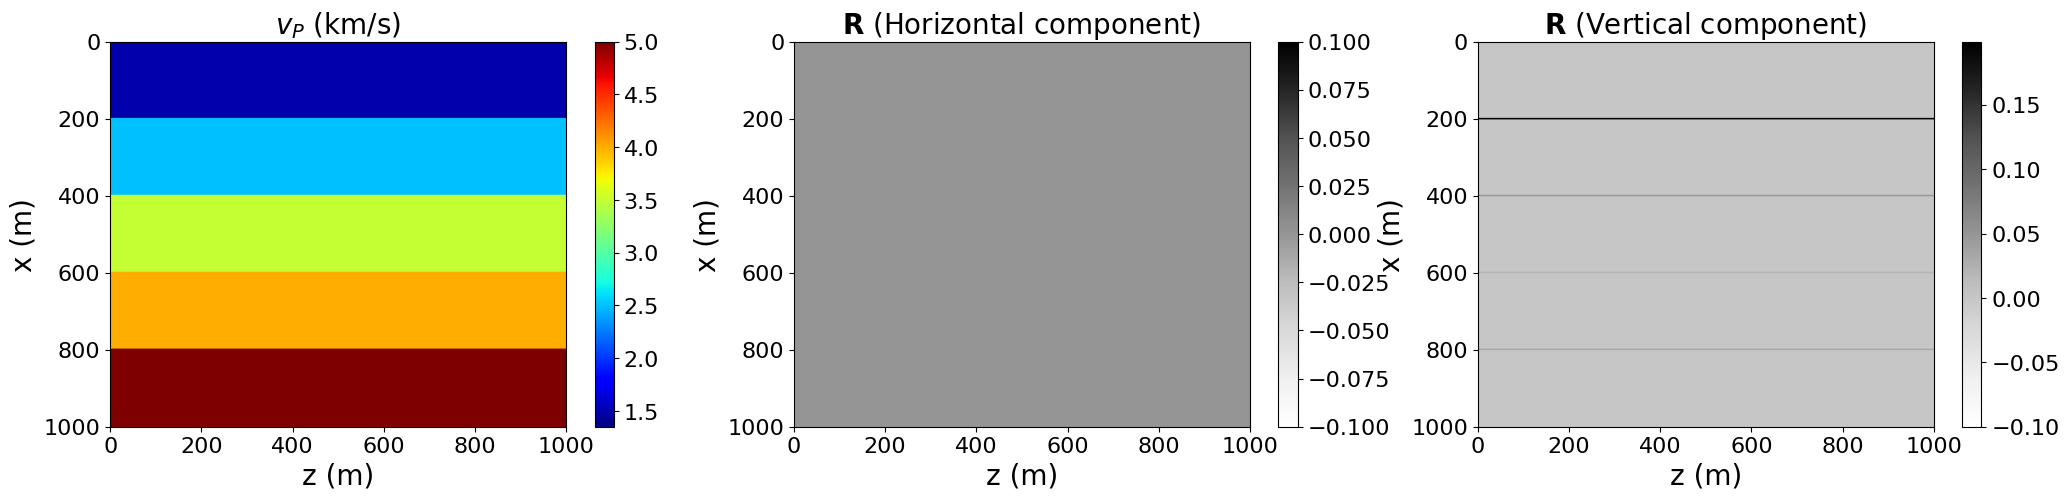

In [198]:
img_model(
    model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model.r[0].data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model.r[1].data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model
)

In [199]:
tn = 1000
f0 = 0.030
# max_dt = (np.max(model.vp.data * 1e3)*(1/SPACING[0]**2 + 1/SPACING[1]**2 - np.min(divr.data)/2)**.5)**-1
# dt = 0.9*max_dt
dt = model.critical_dt

geometry = setup_geometry(model, tn, f0)
geometry.resample(dt)

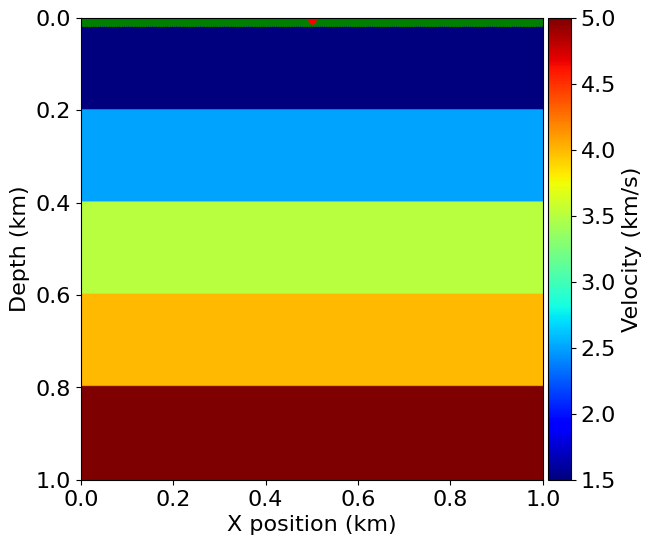

In [200]:
plot_velocity(model, geometry.src_positions, geometry.rec_positions)

## Operators

In [201]:
class OpWrapper():
    def __init__(self, forward, adjoint):
        self.forward = forward
        self.adjoint = adjoint

    def __call__(self, model, geometry, src, rec, **kwargs):
        return self.forward(model, geometry, src, rec, **kwargs)
    
    def T(self, model, geometry, rec, srca=None, **kwargs):
        return self.adjoint(model, geometry, rec, srca, **kwargs)

### Original

The original equation presented in the paper by [Whitmore et al. (2020)](https://doi.org/10.1190/segam2020-3424516.1), but multiplied by $m = \dfrac{1}{v_p^2}$


$$
\begin{aligned}
\mathbf{R} &= \frac{1}{2} \frac{\nabla (v_p \rho)}{v_p \rho}\\
    &= \frac{1}{2}\left( \frac{\nabla v_p}{v_p} + \frac{\nabla \rho}{\rho} \right)\\
    &= \frac{1}{2}\left( \frac{\nabla v_p}{v_p} - \frac{\nabla b}{b} \right)
\end{aligned}
$$

- Forward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \left[ \nabla^2u + \frac{1}{v_p}\nabla v_p \cdot \nabla u - 2 \mathbf{R} \cdot \nabla u \right] = S
    $$
    
    $$
        m\frac{\partial^2 u}{\partial t^2} - \nabla^2u + \left(-\frac{1}{v_p}\nabla v_p + 2 \mathbf{R}\right) \cdot \nabla u = S
    $$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial t^2} - \left[ \nabla^2v + \nabla \cdot \left(\frac{1}{v_p}(\nabla v_p) v\right) - 2  \nabla \cdot \mathbf{R} v \right] = R
    $$
    $$
        m\frac{\partial^2 v}{\partial t^2} - \nabla^2v - \nabla \cdot \left[\left(-\frac{1}{v_p}\nabla v_p + 2 \mathbf{R}\right) v\right] = R
    $$

In [202]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order, staggered=NODE)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp) + 2*r).T * grad(u) + model.damp * u.dt
    

    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model: ModelViscoacoustic, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order, staggered=NODE)
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - v.laplace - div((-grad(vp)/vp + 2*r) * v, .5) + model.damp * v.dt.T
    
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_original = OpWrapper(forward, adjoint)

### Acoustic with constant density

The classical acoustic wave equation.

- Forward and backward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \nabla^2u = S
    $$

In [203]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order)

    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order)
    
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

# L_acoustic = OpWrapper(forward, adjoint)

### Acoustic with variable density

The classical acoustic wave equation with variable density $\rho$.

- Forward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \rho \nabla \cdot \left(\frac{1}{\rho} \nabla u\right) = S
    $$
    or
    $$
        m\frac{\partial^2 u}{\partial t^2} - \frac{1}{b} \nabla \cdot \left(b \nabla u\right) = S
    $$
    where $b = \dfrac{1}{\rho}$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial t^2} - \nabla \cdot \left[b \nabla \left( \frac{v}{b} \right)\right] = R
    $$


In [204]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order, staggered=NODE)

    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*u.dt2 - rho * div(b * grad(u, .5), -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order, staggered=NODE)
    
    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*v.dt2 - div(b * grad(rho * v, .5), -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_acoustic = OpWrapper(forward, adjoint)

## Comparison

### Seismic data computation

In [205]:
src_pos = geometry.src_positions[0]
rec_depth = geometry.rec_positions[0][1]
nrec = geometry.nrec
# nrec = 3
# src_pos = np.array([0.5 * model.domain_size[0], 10.], dtype = model.dtype)
# rec_depth = 0.5*model.domain_size[1]
# nrec = 1

In [206]:
print(src_pos, rec_depth, nrec)

[500.   4.] 8.0 251


In [207]:
# src_modified, rec_modified = src_rec(model, geometry, src_pos, rec_depth, nrec)
# srca_modified = adjoint_src(model, geometry, src_pos)

# u_modified = L_modified(model, geometry, src_modified, rec_modified)
# v_modified = L_modified.T(model, geometry, rec_modified, srca_modified)

In [208]:
src_original, rec_original = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_original = adjoint_src(model, geometry, src_pos)
line_srca_original = adjoint_line_src(model, geometry, src_pos[1], nrec)

u_original = L_original(model, geometry, src_original, rec_original)
v_original = L_original.T(model, geometry, rec_original, srca_original)
_ = L_original.T(model, geometry, rec_original, line_srca_original)

Operator `Kernel` ran in 2.36 s
Operator `Kernel` ran in 3.12 s
Operator `Kernel` ran in 3.16 s


In [209]:
src_acoustic, rec_acoustic = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_acoustic = adjoint_src(model, geometry, src_pos)
line_srca_acoustic = adjoint_line_src(model, geometry, src_pos[1], nrec)

u_acoustic = L_acoustic(model, geometry, src_acoustic, rec_acoustic)
v_acoustic = L_acoustic.T(model, geometry, rec_acoustic, srca_acoustic)
_ = L_acoustic.T(model, geometry, rec_acoustic, line_srca_acoustic)

Operator `Kernel` ran in 2.18 s
Operator `Kernel` ran in 4.84 s
Operator `Kernel` ran in 4.84 s


### Plotting data

In [224]:
def plot_data(recs, names, model, t0, tn, colorbar=True):
    fig, axes = plt.subplots(1, len(recs), figsize=(8*len(recs), 8))

    for i, rec in enumerate(recs):
        ax = (len(recs) > 1) and axes[i] or axes

        scale = np.max(rec) / 10.
        extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
                1e-3*tn, t0]

        plot = ax.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
        ax.set_title(names[i], fontsize=20)
        ax.set_xlabel('X position (km)', fontsize=20)
        if i == 0:
            ax.set_ylabel('Time (s)', fontsize=20)

        # Create aligned colorbar on the right
        # if colorbar and i == len(recs) - 1:
        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(plot, cax=cax)

    plt.tight_layout()
    plt.show()

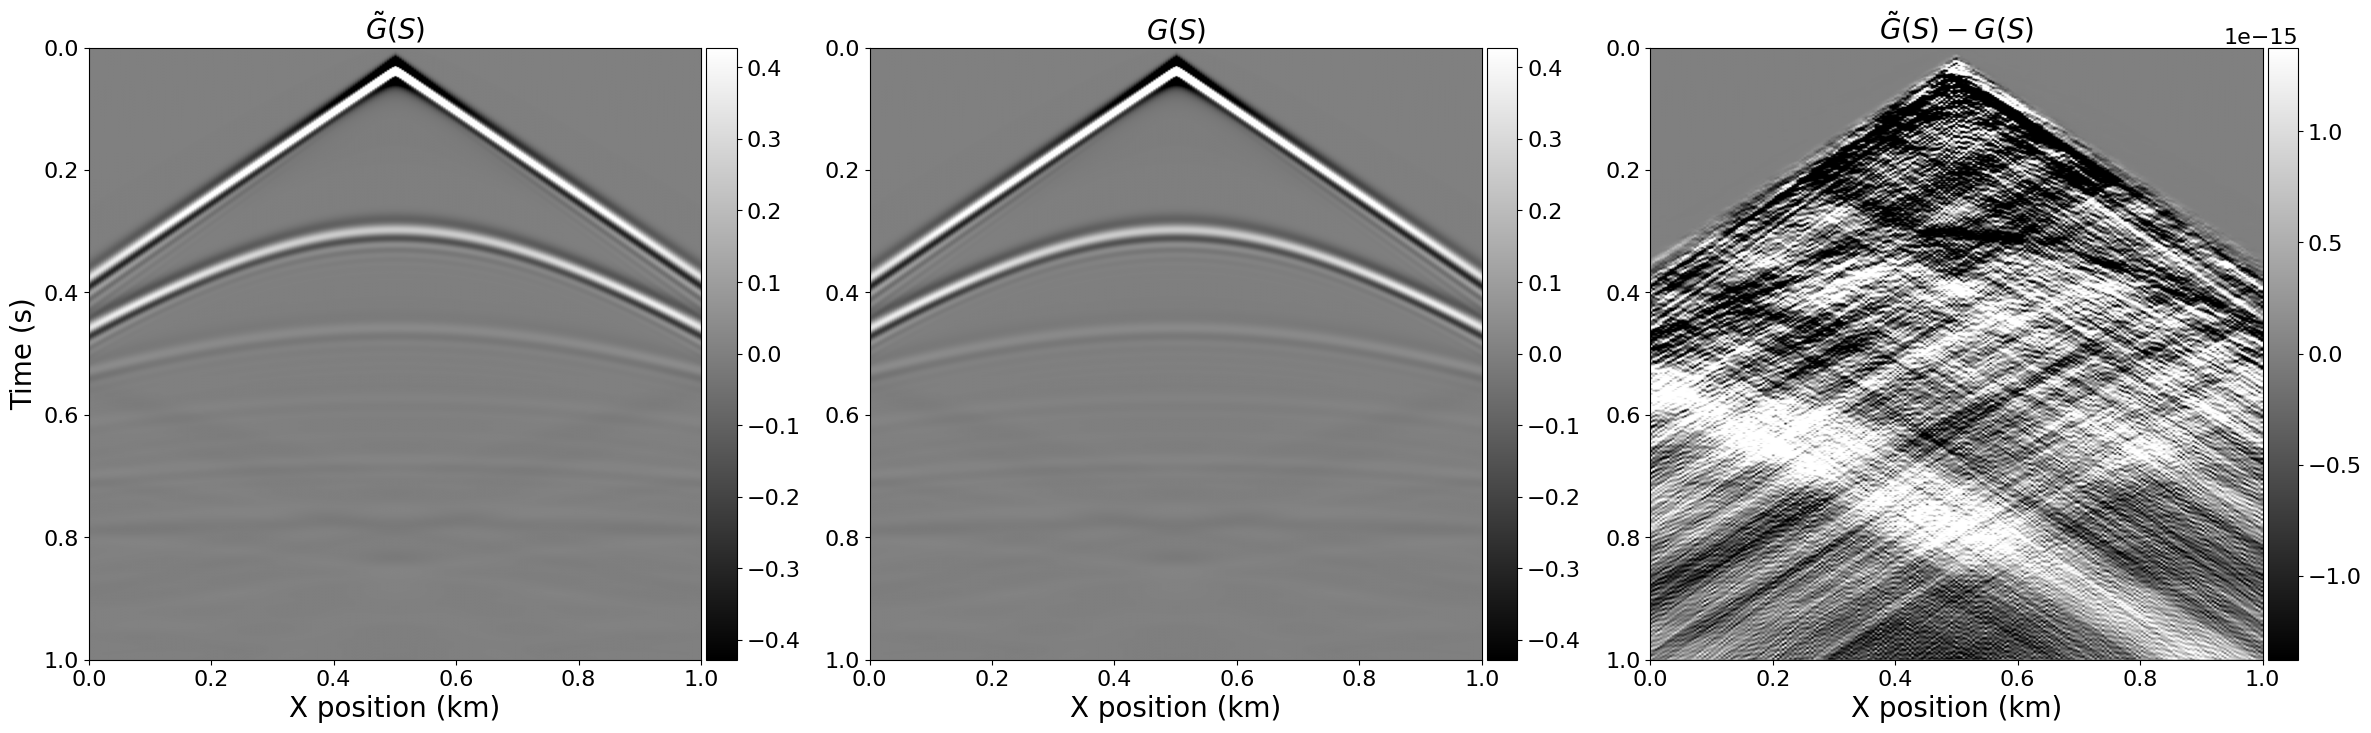

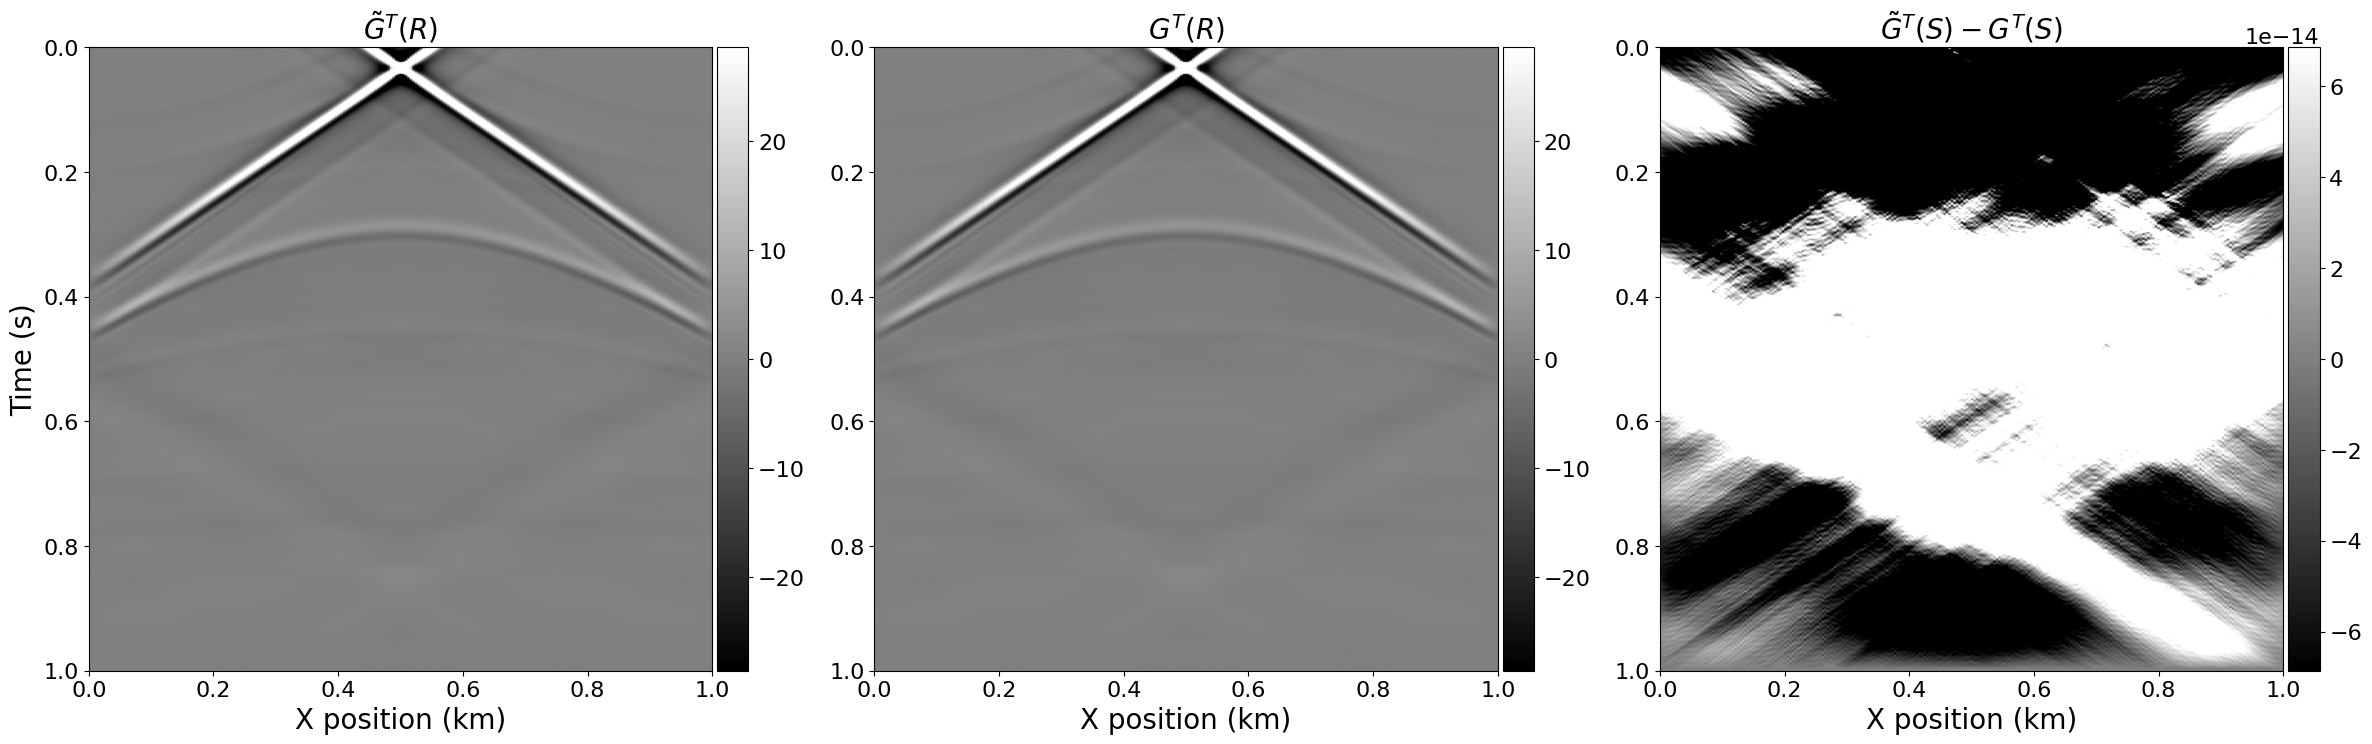

In [225]:
recs = [rec_acoustic.data, rec_original.data, rec_acoustic.data - rec_original.data]
srcas = [line_srca_acoustic.data, line_srca_original.data, line_srca_acoustic.data - line_srca_original.data]
# names = ['Acoustic, Variable Density', 'Vector Reflectivity']
names = ['$\\tilde{G}(S)$', '$G(S)$', '$\\tilde{G}(S)- G(S)$']
namesa = ['$\\tilde{G}^T(R)$', '$G^T(R)$', '$\\tilde{G}^T(S)- G^T(S)$']

plot_data(recs, names, model, geometry.t0, geometry.tn)
plot_data(srcas, namesa, model, geometry.t0, geometry.tn)

In [212]:
def plot_trace(recs, labels, tr_idx, geometry, title='', start_idx = 0):
    t_axis = geometry.time_axis.time_values

    for i, rec in enumerate(recs):
        plt.plot(rec[start_idx:, tr_idx], t_axis[start_idx:], label=labels[i])

        plt.legend(fontsize='small')
        plt.title(title)
        plt.xlabel('Amplitude')
        plt.ylabel('Time (ms)')

        plt.grid()
    plt.gca().invert_yaxis()

    plt.show()

In [213]:
n = np.size(rec_acoustic.data)
RMS = (np.sum((rec_acoustic.data - rec_original.data)**2)/n)**0.5
RMS

Data(1.14433109e-15)

In [214]:
n = np.size(srca_acoustic.data)
RMS_T = (np.sum((srca_acoustic.data - srca_original.data)**2)/n)**0.5
RMS_T

Data(4.21902346e-13)

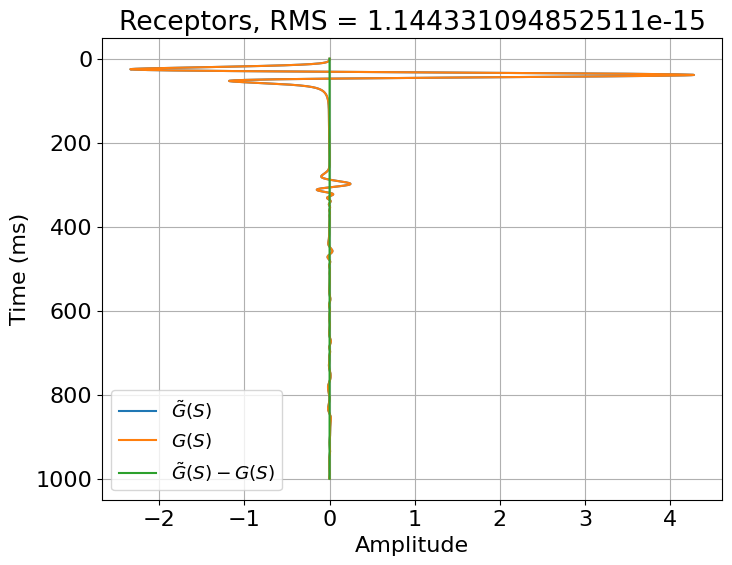

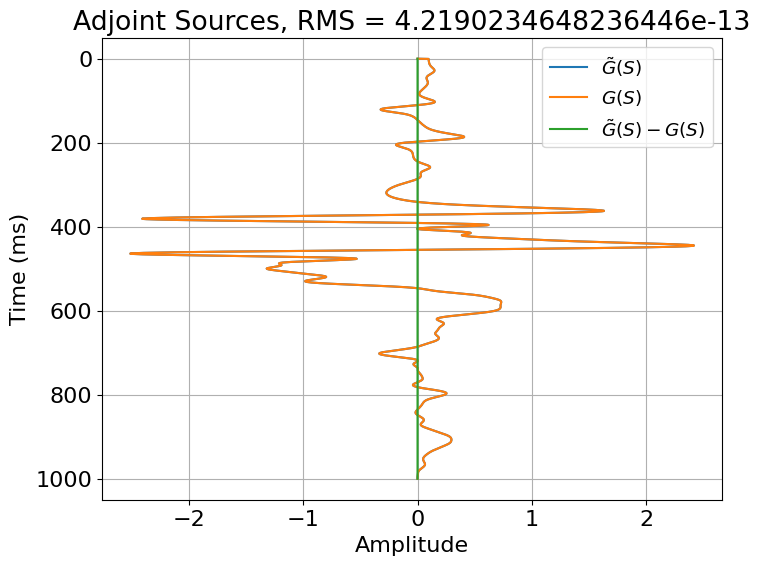

In [215]:
tr_idx = rec_original.data.shape[1]//2
start_idx = 0
# start_idx = int(100/geometry.dt)

plot_trace(recs, names, tr_idx, geometry, f'Receptors, RMS = {RMS}', start_idx=start_idx)
plot_trace(srcas, names, 0, geometry, f'Adjoint Sources, RMS = {RMS_T}', start_idx=start_idx)

## Adjoint Test

In [216]:
if model.dtype == np.float64:
    eps = 1e-11
elif model.dtype == np.float32:
    eps = 1e-6

In [217]:
# term1 = norm(rec_original) ** 2 # <Ax, y>
# term2 = srca_original.data.T @ src_original.data # <x, A^Ty>
term1 = norm(rec_acoustic) ** 2 # <Ax, y>
term2 = srca_acoustic.data.T @ src_acoustic.data # <x, A^Ty>

print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))

assert np.isclose((term1 - term2)/term1, 0., atol=eps)

<x, A*y>: 5537.879792, <Ax,y>: 5537.879792, difference: 8.3758e-15, ratio: 1.000000


/tmp/ipykernel_10982/909337146.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'


In [218]:
np.abs(term1 - term2), np.abs((term1 - term2)/term1)

(Data([[4.63842298e-11]]), Data([[8.37581015e-15]]))

In [219]:
def latex_print(symbol):
    return Latex(f'$${latex(symbol)}$$'.replace('frac', 'dfrac'))